<a href="https://colab.research.google.com/github/Dharren09/MicroscopyNets/blob/main/MaskRCNN_on_microscopy_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install orjson
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 695.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metad

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('seaborn-v0_8-dark-palette')
import subprocess
from pathlib import Path
import os
import skimage
from PIL import Image
import torch
import shutil
import random
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import xml.etree.ElementTree as ET
import json
import orjson
from sklearn.preprocessing import OneHotEncoder
import albumentations as A
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import cv2
from typing import Dict, List, Tuple, Union
import lightning as L


import logging
logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Device configuration

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using '{device}'")

Using 'cpu'


In [6]:
subprocess.run(['unzip', '/content/drive/MyDrive/Colab Notebooks/Machine Learning Datasets/plasmodium-images.zip', '-d', '/content/working_directory'])

CompletedProcess(args=['unzip', '/content/drive/MyDrive/Colab Notebooks/Machine Learning Datasets/plasmodium-images.zip', '-d', '/content/working_directory'], returncode=0)

In [9]:
# directories within the dataset folder

DATA_DIR = Path('/content/working_directory')

print(os.listdir(DATA_DIR))

['images', 'annotation', 'README.txt']


In [11]:
# How many extensions are we dealing
IMAGES_DIR = DATA_DIR / 'images'

ext_map = {} # hash map to follow up and track our extensions

for image in IMAGES_DIR.glob('*'):
  ext = image.suffix
  if ext in ext_map:
    ext_map[ext] += 1
  else:
    ext_map[ext] = 1

ext_map

{'.jpg': 2703}

In [22]:
# Visualize some Images

def visualize_images(image_dir, n_images=12, n_cols=3, image_size=(1024, 768)):
  if not Path(image_dir).is_dir():
    raise ValueError("{} is either an invalid directory or does not exist".format(image_dir))

  image_paths = []
  with os.scandir(image_dir) as entries:
    for entry in entries:
      if entry.is_file():
        image_paths.append(entry.path)
        if len(image_paths) >= n_images:
          break

  # visualization logic
  rows = (len(image_paths) + n_cols - 1) // n_cols
  fig, ax = plt.subplots(rows, n_cols, figsize=(15, 5*rows))

  for idx, image_path in enumerate(image_paths):
    if not Path(image_path).is_file():
      raise ValueError("No image to display in the following {}".format(image_path))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # by default, CV generates BGR images
    image = cv2.resize(image, image_size)

    row = idx // n_cols
    col = idx % n_cols

    ax[row, col].imshow(image)
    ax[row, col].axis('off')

  # Deleting blank or empty axes
  for j in range(len(image_paths), rows * n_cols):
    fig.delaxes(ax[j // n_cols, ax % n_cols])

  plt.tight_layout()
  plt.show()

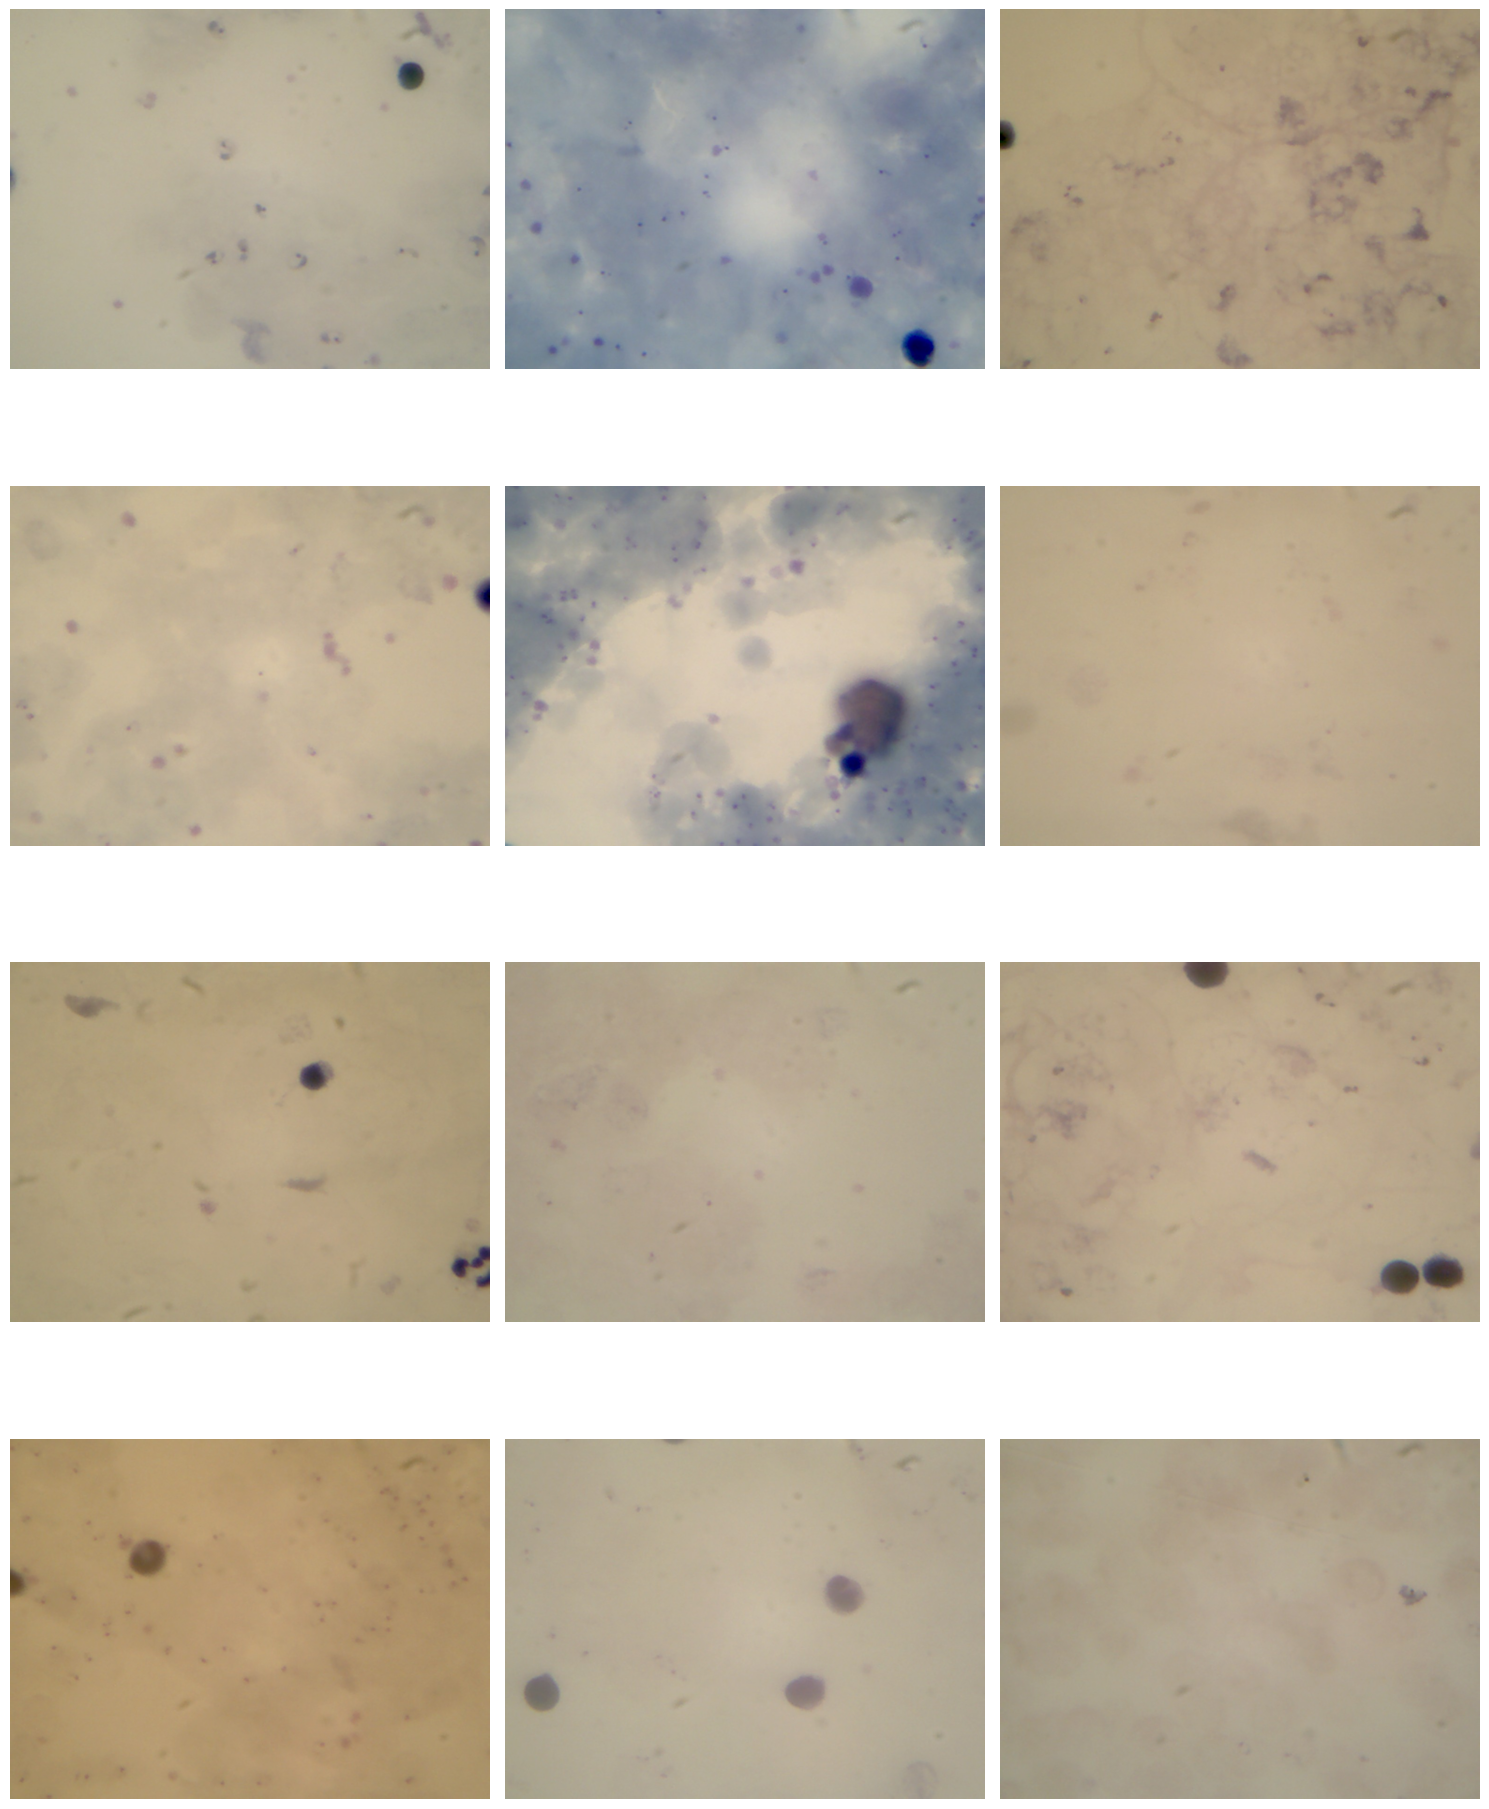

In [23]:
visualize_images(IMAGES_DIR, n_images=12)

# **Train-Validation data splitting**

In [26]:
class TrainValSplitter():
  def __init__(self, images_dir, annotations_dir, output_dir, train_size=0.8):
    super(TrainValSplitter, self).__init__()
    self.images_dir = images_dir
    self.annotations_dir = annotations_dir
    self.output_dir = output_dir
    self.train_size = train_size

  def get_pairs(self):
    image_files = {f.stem: f for f in self.images_dir.glob('*.jpg')} # or we could use just '*' given that i have only one format of images
    annotation_files = {f.stem: f for f in self.annotations_dir.glob('*.xml')}

    # collecting only images that have annotations, validation done based on basename (stem)
    pairs = [(image_files[name], annotation_files[name]) for name in image_files if name in annotation_files]
    return pairs

  def pair_split(self, pairs):
    train_pairs, val_pairs = train_test_split(pairs, train_size=self.train_size, random_state=1332)
    return train_pairs, val_pairs

  def copy_files(self, pairs, subset_name):
    images_output_dir = self.output_dir / subset_name / 'images'
    annotations_output_dir = self.output_dir / subset_name / 'annotations'

    images_output_dir.mkdir(parents=True, exist_ok=True)
    annotations_output_dir.mkdir(parents=True, exist_ok=True)

    for img_file, annot_file in pairs:
      shutil.copy(img_file, images_output_dir / img_file.name)
      shutil.copy(annot_file, annotations_output_dir / annot_file.name)

  def execute(self):
    pairs = self.get_pairs()
    train_pairs, val_pairs = self.pair_split(pairs)

    self.copy_files(train_pairs, 'train')
    self.copy_files(val_pairs, 'val')

    print(f"Training data: {len(train_pairs)} pairs")
    print(f"Validation data: {len(val_pairs)} pairs")
    print(f"Done moving {len(train_pairs) + len(val_pairs)} for 2 respective folders")

In [27]:
# file paths
IMAGES_DIR = DATA_DIR / 'images'
ANNOTATIONS_DIR = DATA_DIR / 'annotation'
OUTPUT_DIR = DATA_DIR / 'TrainValData'

# call
splitter = TrainValSplitter(images_dir=IMAGES_DIR, annotations_dir=ANNOTATIONS_DIR, output_dir=OUTPUT_DIR)
splitter.execute()

Training data: 2162 pairs
Validation data: 541 pairs
Done moving 2703 for 2 respective folders
